## 심층신경망(Deep Neural Network, DNN)

가중치 벡터 w 업데이트 공식(경사하강법 이용)
$$ w:= w+\Delta w$$

$$\downarrow$$

$$\Delta = -\eta\Delta J(w)$$

<br>
가중치 $w_j$에 대한 편도함수
$$\frac{\vartheta}{\vartheta w_j}J(w) = -\sum_i (y^{(i)} - a^{(i)})x_j^{(i)}$$

표기법
$$W^{(h)} \in R^{mxd}$$<br>

$m$: 절편을 포함한 입력 유닛의 개수
$d$: 은닉 유닛의 개수

<b>MLP 학습 과정</b>
1. 입력층에서 시작하여 정방향으로 훈련 데이터의 패턴을 네트워크에 전파하여 출력을 만듦
2. 네트워크의 출력을 기반으로 나중에 설명할 비용함수를 이용하여 최소화해야 할 오차를 계산
3. 네트워크에 있는 모든 가중치에 대한 도함수를 찾아 오차를 역전파하고 모델을 업데이트 함

<br> 이 세 단계를 에포크 동안 반복하고 MLP 가중치를 학습. 그 후, 클래스 레이블을 예측하기 위해 정방향 계산으로 네트워크의 출력을 만들고 임계함수를 적용
<br><br>
최종입력 $z$ -> 활성화 함수$\phi$ -> 활성화 출력 $a$
<br><br>
<b>피드포워드(feed forward)</b>: 입력을 순환시키지 않고 다음 층으로 전달

In [2]:
import os
import struct
import numpy as np

def load_mnist(path, kind = 'train'):#헬퍼 함수
    """'path'에서 MNIST 데이터 불러오기"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte'%kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte'%kind)
    
    with open(labels_path, 'rb') as lbpath:
        magic, n= struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype = np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",imgpath.read(16))
        images = np.fromfile(imgpath, dtype = np.unit8).reshape(len(labels),784)
        images = ((images/255.)-.5)*2
    
    return images, labels

In [9]:
#서버 액세스 안되서 그냥 불러옴
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [10]:
X_train.shape

(60000, 28, 28)

In [11]:
y_train.shape

(60000,)

In [12]:
X_test.shape

(10000, 28, 28)

In [13]:
y_test.shape

(10000,)

In [15]:
X_train = X_train.reshape(60000,784)

In [16]:
X_test = X_test.reshape(-1,784)

In [17]:
np.max(X_train)

255

In [18]:
np.min(X_train)

0

In [19]:
X_train = ((X_train/255.)-.5)*2#MNIST 픽셀 값을 -1에서 1 사이로 정규화

In [20]:
X_test = ((X_test/255.)-.5)*2

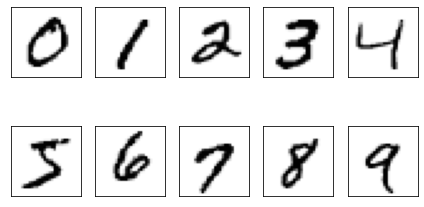

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey= True)

ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28,28)#원본 28x28 이미지로 크기 변경
    ax[i].imshow(img, cmap = 'Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

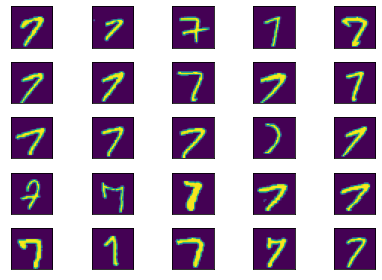

In [23]:
#숫자 7의 이미지 중에 처음 25개 시각화
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(25):#처음 25개
    img = X_train[y_train==7][i].reshape(28,28)#숫자 7
    ax[i].imshow(img)#, cmap='Greys')

    ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

<b>savez 함수는 넘파이 배열을 저장하는데 최적화 됨</b>

In [24]:
import numpy as np
np.savez_compressed('mnist_scaled.npz',#넘파이 배열을 작은 크기로 압축하여 저장
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test)

In [25]:
mnist = np.load('mnist_scaled.npz')#MNIST 이미지 배열 로드

In [26]:
mnist.files #객체에 있는 데이터 배열 참조

['X_train', 'y_train', 'X_test', 'y_test']

In [27]:
X_train = mnist['X_train']#딕셔너리 처럼 로드

In [28]:
X_train, y_train, X_test, y_test = [mnist[f] for f in mnist.files]

### 다층 퍼셉트론 구현

In [69]:
import numpy as np
import sys

class NeuralNetMLP(object):#다층 퍼셉트론
    def __init__(self, n_hidden = 30,
                l2 = 0., epochs = 100, eta = 0.001, shuffle = True, minibatch_size = 1, seed = None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden#은닉 유닛 개수
        self.l2 = l2 #람다 값(L2 규제)
        self.epochs = epochs#훈련세트를 반복할 횟수
        self.eta = eta#학습률
        self.shuffle = shuffle #에포크마다 훈련 섞을지 여부
        self.minibatch_size = minibatch_size#미니 배치의 훈련 샘플 개수
    
    def _onehot(self,y,n_classes):#원-핫 인코딩
        
        onehot = np.zeros((n_classes,y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T#레이블을 원-핫 방식으로 인코딩
    
    
    def _sigmoid(self, z):#로지스틱 함수(활성화 함수)
        return 1./(1.+np.exp(-np.clip(z,-250,250)))#시그모이드
    
    
    def _forward(self,X):#정방향 계산 forward propagation
        #단계1: 은닉층의 최종 입력
        z_h = np.dot(X, self.w_h)+self.b_h#가중치 합 계산
        
        #단계2: 은닉층의 활성화 출력
        a_h = self._sigmoid(z_h)
        
        #단계3: 출력층의 최종 입력
        z_out = np.dot(a_h, self.w_out)+self.b_out
        
        #단계4: 출력층의 활성화 출력
        a_out = self._sigmoid(z_out)
        
        return z_h, a_h, z_out, a_out#은닉층의 최종입력, 은닉층의 활성화 출력, 출력층의 최종입력, 출력층의 활성화 출력 반환
    
    def _compute_cost(self,y_enc, output):#비용 함수 계산
        L2_term = (self.l2 *(np.sum(self.w_h **2.)+#은닉층 가중치
                            np.sum(self.w_out **2.)))#출력층 가중치
        
        term1 = -y_enc*(np.log(output))
        term2 = (1.-y_enc)*np.log(1.-output)
        cost = np.sum(term1-term2)+L2_term
        return cost#비용 반환 (규제 포함)
    
    def predict(self,X):#예측
        """클래스 레이블을 예측"""
        z_h, a_h, z_out, a_out = self._forward(X)#정방향
        y_pred = np.argmax(z_out, axis=1)#가장 큰 값의 인덱스 반환
        return y_pred
    
    def fit(self, X_train,y_train,X_valid,y_valid):#학습
        
        """"훈련 데이터에서 가중치 학습"""
        
        n_output = np.unique(y_train).shape[0]#클래스 레이블 개수
        n_features = X_train.shape[1]#픽셀 값(원래는 특성 개수)
        
        #########가중치 초기화#########
        
        #입력층->은닉층 사이의 가중치
        self.b_h = np.zeros(self.n_hidden)#절편 초기화
        self.w_h = self.random.normal(loc = 0.0, scale = 0.1, 
                                     size = (n_features, self.n_hidden))#가중치 초기화
        
        #은닉층->출력층 사이의 가중치
        self.b_out = np.zeros(n_output)#절편 초기화
        self.w_out = self.random.normal(loc = 0.0, scale =0.1, 
                                       size = (self.n_hidden, n_output))#가중치 초기화
        
        epoch_strlen = len(str(self.epochs))#출력 포맷 위해
        
        self.eval_ = {'cost':[], 'train_acc':[], 'valid_acc':[]}
        
        y_train_enc = self._onehot(y_train,n_output)#인코딩(타깃값, 클래스 레이블 개수)
        
        #훈련 에포크를 반복
        for i in range(self.epochs):
            #미니 배치로 반복
            indices = np.arange(X_train.shape[0])
            
            if self.shuffle:#에포크 마다 훈련 세트 섞기
                self.random.shuffle(indices)
            
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx: start_idx + self.minibatch_size]
                
                #정방향 계산
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])
                
                
                ###########역전파###########
                sigma_out = a_out - y_train_enc[batch_idx]#출력층의 오차벡터
                
                sigmoid_derivative_h = a_h*(1.-a_h)#시그모이드 활성화 함수의 도함수
                
                sigma_h = (np.dot(sigma_out, self.w_out.T)*sigmoid_derivative_h)#은닉층의 오차행렬
                
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis = 0)
                
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out,axis=0)
                
                ######규제와 가중치 업데이트
                #은닉층
                delta_w_h = (grad_w_h + self.l2*self.w_h)#가중치 규제
                delta_b_h = grad_b_h#편향은 규제하지 않음
                self.w_h -= self.eta * delta_w_h#그래디언트 반대 방향으로
                self.b_h -= self.eta *delta_b_h#가중치 업데이트
                
                #출력층
                delta_w_out = (grad_w_out + self.l2*self.w_out)#규제
                delta_b_out = grad_b_out#편향은 규제하지 않음
                self.w_out -= self.eta *delta_w_out#그래디언트 반대 방향으로
                self.b_out -= self.eta*delta_b_out#가중치 업데이트
                
                
                
             #############평가
            #훈련하는 동안 에포크마다 평가
            z_h, a_h, z_out, a_out = self._forward(X_train)
            cost = self._compute_cost(y_enc= y_train_enc, output=a_out)#손실
                
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
                
            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float)/X_train.shape[0])#훈련 정확도
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float)/X_valid.shape[0])#검증 정확도
                
            sys.stderr.write('lr%0*d/%d | 비용: %.2f'
                                '| 훈련/검증 정확도: %.2f%%/%.2f%%'%(
                                epoch_strlen, i+1, self.epochs, cost, train_acc *100, valid_acc*100))
                
            sys.stderr.flush()
                
            self.eval_['cost'].append(cost)#비용
            self.eval_['train_acc'].append(train_acc)#훈련 정확도
            self.eval_['valid_acc'].append(valid_acc)#검증 정확도
            
        return self

In [70]:
#MLP 만들기
nn = NeuralNetMLP(n_hidden=100,#은닉유닛
                 l2=0.001,#과대적합을 줄이기 위한 L2 규제의 lambda 파라미터
                 epochs=200,#훈련 세트를 반복할 횟수
                 eta=0.0005,#학습률
                 minibatch_size=100,#미니배치 크기
                 shuffle=True,#섞기
                 seed=1)

In [71]:
#훈련
nn.fit(X_train=X_train[:55000],
      y_train=y_train[:55000],
      X_valid=X_train[55000:],
      y_valid=y_train[55000:])

lr001/200 | 비용: 66678.24| 훈련/검증 정확도: 84.54%/88.90%lr002/200 | 비용: 47751.95| 훈련/검증 정확도: 88.34%/91.74%lr003/200 | 비용: 40245.00| 훈련/검증 정확도: 89.64%/92.72%lr004/200 | 비용: 35962.93| 훈련/검증 정확도: 90.57%/93.16%lr005/200 | 비용: 33314.57| 훈련/검증 정확도: 91.14%/93.44%lr006/200 | 비용: 31067.94| 훈련/검증 정확도: 91.74%/93.74%lr007/200 | 비용: 29596.57| 훈련/검증 정확도: 92.13%/94.18%lr008/200 | 비용: 28042.68| 훈련/검증 정확도: 92.56%/94.28%lr009/200 | 비용: 26822.92| 훈련/검증 정확도: 92.90%/94.68%lr010/200 | 비용: 25764.91| 훈련/검증 정확도: 93.11%/95.00%lr011/200 | 비용: 25022.77| 훈련/검증 정확도: 93.26%/94.88%lr012/200 | 비용: 24037.73| 훈련/검증 정확도: 93.67%/95.00%lr013/200 | 비용: 23189.20| 훈련/검증 정확도: 93.90%/95.24%lr014/200 | 비용: 22714.76| 훈련/검증 정확도: 93.98%/95.32%lr015/200 | 비용: 22078.62| 훈련/검증 정확도: 94.25%/95.64%lr016/200 | 비용: 21276.98| 훈련/검증 정확도: 94.37%/95.68%lr017/200 | 비용: 20876.43| 훈련/검증 정확도: 94.54%/95.66%lr018/200 | 비용: 20155.10| 훈련/검증 정확도: 94.72%/95.96%lr019/200 | 비용: 19819.60| 훈련/검증 정확도: 94.83%/96.00%lr020/200 | 비용: 19357.21| 훈련/검증 정확도: 95.02%/96.14%

lr167/200 | 비용: 4485.26| 훈련/검증 정확도: 99.33%/97.96%lr168/200 | 비용: 4422.49| 훈련/검증 정확도: 99.37%/97.92%lr169/200 | 비용: 4447.65| 훈련/검증 정확도: 99.38%/97.98%lr170/200 | 비용: 4456.15| 훈련/검증 정확도: 99.35%/97.94%lr171/200 | 비용: 4383.20| 훈련/검증 정확도: 99.39%/97.90%lr172/200 | 비용: 4346.69| 훈련/검증 정확도: 99.40%/97.84%lr173/200 | 비용: 4308.99| 훈련/검증 정확도: 99.41%/97.92%lr174/200 | 비용: 4308.07| 훈련/검증 정확도: 99.41%/98.00%lr175/200 | 비용: 4289.99| 훈련/검증 정확도: 99.42%/97.90%lr176/200 | 비용: 4232.06| 훈련/검증 정확도: 99.41%/98.00%lr177/200 | 비용: 4206.65| 훈련/검증 정확도: 99.42%/97.96%lr178/200 | 비용: 4181.05| 훈련/검증 정확도: 99.43%/97.96%lr179/200 | 비용: 4207.58| 훈련/검증 정확도: 99.41%/98.02%lr180/200 | 비용: 4132.82| 훈련/검증 정확도: 99.45%/97.92%lr181/200 | 비용: 4106.47| 훈련/검증 정확도: 99.45%/97.98%lr182/200 | 비용: 4098.30| 훈련/검증 정확도: 99.45%/97.98%lr183/200 | 비용: 4070.79| 훈련/검증 정확도: 99.48%/97.94%lr184/200 | 비용: 4147.83| 훈련/검증 정확도: 99.45%/97.92%lr185/200 | 비용: 4045.48| 훈련/검증 정확도: 99.45%/97.94%lr186/200 | 비용: 4004.98| 훈련/검증 정확도: 99.48%/97.96%lr187/200 | 비용: 3971

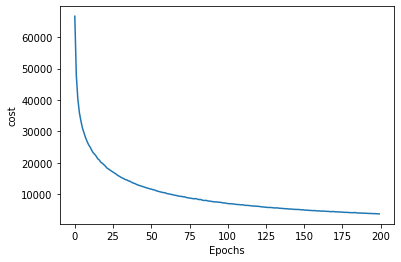

In [72]:
#200 번의 에포크 동안의 비용 시각화
import matplotlib.pyplot as plt
plt.plot(range(nn.epochs),nn.eval_['cost'])
plt.ylabel('cost')
plt.xlabel('Epochs')
plt.show()#다층 퍼셉트론의 비용 함수

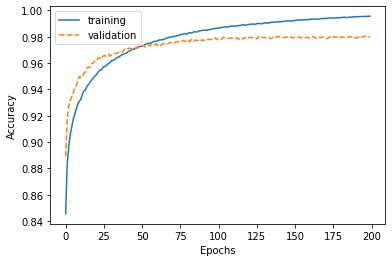

In [73]:
#다층 퍼셉트론의 정확도
plt.plot(range(nn.epochs), nn.eval_['train_acc'],label = 'training')
plt.plot(range(nn.epochs),nn.eval_['valid_acc'],label='validation',linestyle = '--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [74]:
#모델 일반화 성능 평가
y_test_pred = nn.predict(X_test)#테스트세트예측
acc = (np.sum(y_test == y_test_pred).astype(np.float)/X_test.shape[0])
print("테스트 정확도: %.2f%%"%(acc*100))

테스트 정확도: 97.45%


잘못 판단된 이미지 개수 255


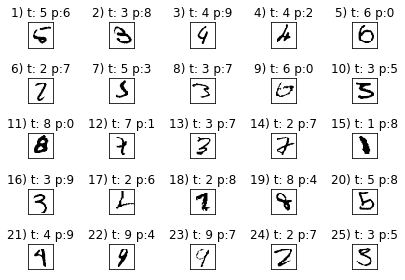

In [76]:
#잘못 판단한 이미지의 원래 답과 예측 시각화(25개)

print("잘못 판단된 이미지 개수",len(y_test[y_test != y_test_pred]))

miscl_img = X_test[y_test != y_test_pred][:25]#잘못 판단한 이미지
correct_lab = y_test[y_test != y_test_pred][:25]#잘못 판단한 이미지의 정답 레이블
miscl_lab = y_test_pred[y_test!=y_test_pred][:25]#잘못 판단한 이미지의 예측된 레이블

fig,ax = plt.subplots(nrows =5,
                     ncols = 5,
                     sharex = True,
                     sharey=True)
ax = ax.flatten()

for i in range(25):
    img = miscl_img[i].reshape(28,28)
    ax[i].imshow(img,
                cmap='Greys',
                interpolation = 'nearest')
    ax[i].set_title('%d) t: %d p:%d'%(i+1, correct_lab[i],miscl_lab[i]) )#t:답, p:예측

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

<b>에포크 늘리면 성능이 더 나아질까?</b>

In [77]:
#MLP 만들기
nn1 = NeuralNetMLP(n_hidden=100,#은닉유닛
                 l2=0.001,#과대적합을 줄이기 위한 L2 규제의 lambda 파라미터
                 epochs=600,#####################훈련 세트를 반복할 횟수(200->600)
                 eta=0.0005,#학습률
                 minibatch_size=100,#미니배치 크기
                 shuffle=True,#섞기
                 seed=1)

In [78]:
#훈련
nn1.fit(X_train=X_train[:55000],
      y_train=y_train[:55000],
      X_valid=X_train[55000:],
      y_valid=y_train[55000:])

lr001/600 | 비용: 66678.24| 훈련/검증 정확도: 84.54%/88.90%lr002/600 | 비용: 47751.95| 훈련/검증 정확도: 88.34%/91.74%lr003/600 | 비용: 40245.00| 훈련/검증 정확도: 89.64%/92.72%lr004/600 | 비용: 35962.93| 훈련/검증 정확도: 90.57%/93.16%lr005/600 | 비용: 33314.57| 훈련/검증 정확도: 91.14%/93.44%lr006/600 | 비용: 31067.94| 훈련/검증 정확도: 91.74%/93.74%lr007/600 | 비용: 29596.57| 훈련/검증 정확도: 92.13%/94.18%lr008/600 | 비용: 28042.68| 훈련/검증 정확도: 92.56%/94.28%lr009/600 | 비용: 26822.92| 훈련/검증 정확도: 92.90%/94.68%lr010/600 | 비용: 25764.91| 훈련/검증 정확도: 93.11%/95.00%lr011/600 | 비용: 25022.77| 훈련/검증 정확도: 93.26%/94.88%lr012/600 | 비용: 24037.73| 훈련/검증 정확도: 93.67%/95.00%lr013/600 | 비용: 23189.20| 훈련/검증 정확도: 93.90%/95.24%lr014/600 | 비용: 22714.76| 훈련/검증 정확도: 93.98%/95.32%lr015/600 | 비용: 22078.62| 훈련/검증 정확도: 94.25%/95.64%lr016/600 | 비용: 21276.98| 훈련/검증 정확도: 94.37%/95.68%lr017/600 | 비용: 20876.43| 훈련/검증 정확도: 94.54%/95.66%lr018/600 | 비용: 20155.10| 훈련/검증 정확도: 94.72%/95.96%lr019/600 | 비용: 19819.60| 훈련/검증 정확도: 94.83%/96.00%lr020/600 | 비용: 19357.21| 훈련/검증 정확도: 95.02%/96.14%

lr167/600 | 비용: 4485.26| 훈련/검증 정확도: 99.33%/97.96%lr168/600 | 비용: 4422.49| 훈련/검증 정확도: 99.37%/97.92%lr169/600 | 비용: 4447.65| 훈련/검증 정확도: 99.38%/97.98%lr170/600 | 비용: 4456.15| 훈련/검증 정확도: 99.35%/97.94%lr171/600 | 비용: 4383.20| 훈련/검증 정확도: 99.39%/97.90%lr172/600 | 비용: 4346.69| 훈련/검증 정확도: 99.40%/97.84%lr173/600 | 비용: 4308.99| 훈련/검증 정확도: 99.41%/97.92%lr174/600 | 비용: 4308.07| 훈련/검증 정확도: 99.41%/98.00%lr175/600 | 비용: 4289.99| 훈련/검증 정확도: 99.42%/97.90%lr176/600 | 비용: 4232.06| 훈련/검증 정확도: 99.41%/98.00%lr177/600 | 비용: 4206.65| 훈련/검증 정확도: 99.42%/97.96%lr178/600 | 비용: 4181.05| 훈련/검증 정확도: 99.43%/97.96%lr179/600 | 비용: 4207.58| 훈련/검증 정확도: 99.41%/98.02%lr180/600 | 비용: 4132.82| 훈련/검증 정확도: 99.45%/97.92%lr181/600 | 비용: 4106.47| 훈련/검증 정확도: 99.45%/97.98%lr182/600 | 비용: 4098.30| 훈련/검증 정확도: 99.45%/97.98%lr183/600 | 비용: 4070.79| 훈련/검증 정확도: 99.48%/97.94%lr184/600 | 비용: 4147.83| 훈련/검증 정확도: 99.45%/97.92%lr185/600 | 비용: 4045.48| 훈련/검증 정확도: 99.45%/97.94%lr186/600 | 비용: 4004.98| 훈련/검증 정확도: 99.48%/97.96%lr187/600 | 비용: 3971

lr335/600 | 비용: 2048.53| 훈련/검증 정확도: 99.89%/97.98%lr336/600 | 비용: 2018.00| 훈련/검증 정확도: 99.90%/98.00%lr337/600 | 비용: 2014.84| 훈련/검증 정확도: 99.90%/98.04%lr338/600 | 비용: 2000.30| 훈련/검증 정확도: 99.89%/98.00%lr339/600 | 비용: 1999.05| 훈련/검증 정확도: 99.89%/98.00%lr340/600 | 비용: 1985.10| 훈련/검증 정확도: 99.91%/98.04%lr341/600 | 비용: 1992.14| 훈련/검증 정확도: 99.91%/97.98%lr342/600 | 비용: 1986.37| 훈련/검증 정확도: 99.91%/98.00%lr343/600 | 비용: 1962.86| 훈련/검증 정확도: 99.90%/98.00%lr344/600 | 비용: 2019.41| 훈련/검증 정확도: 99.89%/98.00%lr345/600 | 비용: 1955.55| 훈련/검증 정확도: 99.91%/98.04%lr346/600 | 비용: 1952.64| 훈련/검증 정확도: 99.91%/98.02%lr347/600 | 비용: 1948.06| 훈련/검증 정확도: 99.90%/97.98%lr348/600 | 비용: 1964.78| 훈련/검증 정확도: 99.89%/97.96%lr349/600 | 비용: 1975.86| 훈련/검증 정확도: 99.90%/98.02%lr350/600 | 비용: 1920.71| 훈련/검증 정확도: 99.90%/98.04%lr351/600 | 비용: 1932.76| 훈련/검증 정확도: 99.91%/98.00%lr352/600 | 비용: 1932.99| 훈련/검증 정확도: 99.90%/98.02%lr353/600 | 비용: 1911.15| 훈련/검증 정확도: 99.91%/98.00%lr354/600 | 비용: 1898.79| 훈련/검증 정확도: 99.91%/98.00%lr355/600 | 비용: 1922

lr503/600 | 비용: 1239.58| 훈련/검증 정확도: 99.97%/98.02%lr504/600 | 비용: 1250.41| 훈련/검증 정확도: 99.97%/97.98%lr505/600 | 비용: 1240.76| 훈련/검증 정확도: 99.97%/98.00%lr506/600 | 비용: 1226.48| 훈련/검증 정확도: 99.97%/98.00%lr507/600 | 비용: 1236.29| 훈련/검증 정확도: 99.97%/98.04%lr508/600 | 비용: 1230.41| 훈련/검증 정확도: 99.97%/98.02%lr509/600 | 비용: 1221.65| 훈련/검증 정확도: 99.97%/97.98%lr510/600 | 비용: 1226.01| 훈련/검증 정확도: 99.97%/98.04%lr511/600 | 비용: 1226.29| 훈련/검증 정확도: 99.97%/98.06%lr512/600 | 비용: 1227.51| 훈련/검증 정확도: 99.97%/98.00%lr513/600 | 비용: 1227.80| 훈련/검증 정확도: 99.97%/97.98%lr514/600 | 비용: 1209.22| 훈련/검증 정확도: 99.97%/98.00%lr515/600 | 비용: 1207.32| 훈련/검증 정확도: 99.97%/97.98%lr516/600 | 비용: 1209.51| 훈련/검증 정확도: 99.97%/98.02%lr517/600 | 비용: 1200.14| 훈련/검증 정확도: 99.97%/98.00%lr518/600 | 비용: 1213.14| 훈련/검증 정확도: 99.98%/98.02%lr519/600 | 비용: 1193.25| 훈련/검증 정확도: 99.98%/98.00%lr520/600 | 비용: 1199.61| 훈련/검증 정확도: 99.97%/97.96%lr521/600 | 비용: 1191.35| 훈련/검증 정확도: 99.98%/98.04%lr522/600 | 비용: 1185.80| 훈련/검증 정확도: 99.97%/98.00%lr523/600 | 비용: 1188

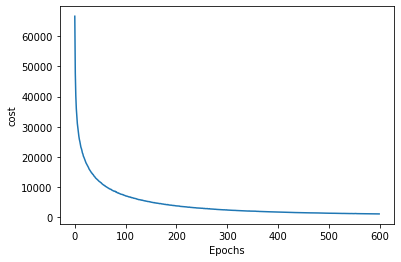

In [80]:
#600 번의 에포크 동안의 비용 시각화
import matplotlib.pyplot as plt
plt.plot(range(nn1.epochs),nn1.eval_['cost'])
plt.ylabel('cost')
plt.xlabel('Epochs')
plt.show()#다층 퍼셉트론의 비용 함수

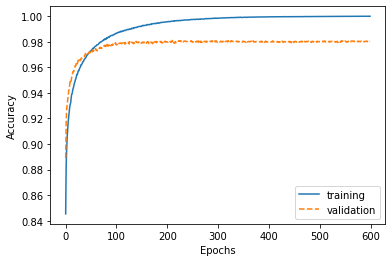

In [82]:
#다층 퍼셉트론의 정확도
plt.plot(range(nn1.epochs), nn1.eval_['train_acc'],label = 'training')
plt.plot(range(nn1.epochs),nn1.eval_['valid_acc'],label='validation',linestyle = '--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()#엄청난 과대적합..ㅋㅋ

In [83]:
#모델 일반화 성능 평가
y_test_pred = nn1.predict(X_test)#테스트세트예측
acc = (np.sum(y_test == y_test_pred).astype(np.float)/X_test.shape[0])
print("테스트 정확도: %.2f%%"%(acc*100))

테스트 정확도: 97.58%


<b> 규제 강도를 높이면 성능이 더 나아질까?</b>

In [84]:
#MLP 만들기
nn2 = NeuralNetMLP(n_hidden=100,#은닉유닛
                 l2=0.01,#######################과대적합을 줄이기 위한 L2 규제의 lambda 파라미터(0.001->0.01)
                 epochs=200,#훈련 세트를 반복할 횟수
                 eta=0.0005,#학습률
                 minibatch_size=100,#미니배치 크기
                 shuffle=True,#섞기
                 seed=1)

In [85]:
#훈련
nn2.fit(X_train=X_train[:55000],
      y_train=y_train[:55000],
      X_valid=X_train[55000:],
      y_valid=y_train[55000:])

lr001/200 | 비용: 66739.71| 훈련/검증 정확도: 84.53%/88.86%lr002/200 | 비용: 47830.40| 훈련/검증 정확도: 88.34%/91.74%lr003/200 | 비용: 40336.64| 훈련/검증 정확도: 89.64%/92.70%lr004/200 | 비용: 36066.12| 훈련/검증 정확도: 90.55%/93.12%lr005/200 | 비용: 33432.26| 훈련/검증 정확도: 91.11%/93.42%lr006/200 | 비용: 31197.73| 훈련/검증 정확도: 91.72%/93.76%lr007/200 | 비용: 29736.45| 훈련/검증 정확도: 92.10%/94.14%lr008/200 | 비용: 28197.88| 훈련/검증 정확도: 92.54%/94.28%lr009/200 | 비용: 26990.73| 훈련/검증 정확도: 92.88%/94.68%lr010/200 | 비용: 25941.66| 훈련/검증 정확도: 93.08%/94.96%lr011/200 | 비용: 25213.82| 훈련/검증 정확도: 93.22%/94.86%lr012/200 | 비용: 24237.90| 훈련/검증 정확도: 93.63%/94.98%lr013/200 | 비용: 23398.20| 훈련/검증 정확도: 93.86%/95.18%lr014/200 | 비용: 22941.42| 훈련/검증 정확도: 93.92%/95.30%lr015/200 | 비용: 22316.23| 훈련/검증 정확도: 94.21%/95.64%lr016/200 | 비용: 21520.40| 훈련/검증 정확도: 94.34%/95.64%lr017/200 | 비용: 21130.86| 훈련/검증 정확도: 94.50%/95.62%lr018/200 | 비용: 20420.45| 훈련/검증 정확도: 94.71%/95.96%lr019/200 | 비용: 20089.15| 훈련/검증 정확도: 94.77%/96.02%lr020/200 | 비용: 19635.96| 훈련/검증 정확도: 94.98%/96.16%

lr167/200 | 비용: 5687.22| 훈련/검증 정확도: 99.11%/97.94%lr168/200 | 비용: 5625.63| 훈련/검증 정확도: 99.15%/98.02%lr169/200 | 비용: 5672.73| 훈련/검증 정확도: 99.12%/98.00%lr170/200 | 비용: 5691.65| 훈련/검증 정확도: 99.12%/97.92%lr171/200 | 비용: 5628.05| 훈련/검증 정확도: 99.13%/97.94%lr172/200 | 비용: 5580.77| 훈련/검증 정확도: 99.16%/98.00%lr173/200 | 비용: 5555.67| 훈련/검증 정확도: 99.13%/97.98%lr174/200 | 비용: 5562.13| 훈련/검증 정확도: 99.16%/98.04%lr175/200 | 비용: 5565.07| 훈련/검증 정확도: 99.14%/98.00%lr176/200 | 비용: 5492.84| 훈련/검증 정확도: 99.18%/98.06%lr177/200 | 비용: 5451.41| 훈련/검증 정확도: 99.17%/98.06%lr178/200 | 비용: 5459.32| 훈련/검증 정확도: 99.17%/98.04%lr179/200 | 비용: 5490.35| 훈련/검증 정확도: 99.17%/97.94%lr180/200 | 비용: 5407.13| 훈련/검증 정확도: 99.18%/98.08%lr181/200 | 비용: 5377.37| 훈련/검증 정확도: 99.20%/98.00%lr182/200 | 비용: 5374.06| 훈련/검증 정확도: 99.18%/98.04%lr183/200 | 비용: 5382.26| 훈련/검증 정확도: 99.21%/98.12%lr184/200 | 비용: 5491.85| 훈련/검증 정확도: 99.16%/97.92%lr185/200 | 비용: 5353.82| 훈련/검증 정확도: 99.21%/98.08%lr186/200 | 비용: 5299.34| 훈련/검증 정확도: 99.22%/98.02%lr187/200 | 비용: 5277

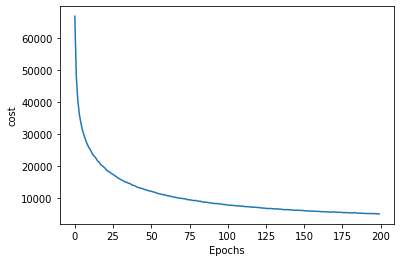

In [87]:
#200 번의 에포크 동안의 비용 시각화
import matplotlib.pyplot as plt
plt.plot(range(nn2.epochs),nn2.eval_['cost'])
plt.ylabel('cost')
plt.xlabel('Epochs')
plt.show()#다층 퍼셉트론의 비용 함수

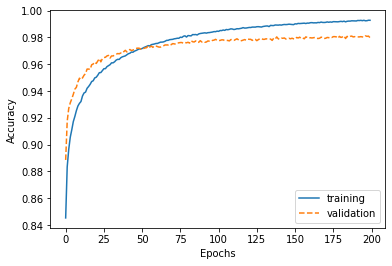

In [88]:
#다층 퍼셉트론의 정확도
plt.plot(range(nn2.epochs), nn2.eval_['train_acc'],label = 'training')
plt.plot(range(nn2.epochs),nn2.eval_['valid_acc'],label='validation',linestyle = '--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [89]:
#모델 일반화 성능 평가
y_test_pred = nn2.predict(X_test)#테스트세트예측
acc = (np.sum(y_test == y_test_pred).astype(np.float)/X_test.shape[0])
print("테스트 정확도: %.2f%%"%(acc*100))

테스트 정확도: 97.54%
